# Pytorch Text - Translation With A Sqeuence To Sequence Network and Attention
Notebook for following along with Pytorch Text NLP From Scratch tutorials that is looking at creating a NN to translate French to English [Pytorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)  website tutorial. <br><br>
The data can be downloaded [here](https://download.pytorch.org/tutorial/data.zip).

### Choices for data

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [1]:
#Import cell
import glob
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import os
import pandas as pd
import pickle as pk
import random
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import unicodedata

from __future__ import unicode_literals, print_function, division
from io import open
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}. Cuda available: {torch.cuda.is_available()}")
print("Imports complete")

Device: cpu. Cuda available: False
Imports complete


<br>

### Importing and preparing data sets
Importing and preparing the data for the models.

In [2]:
#Gather datasets and prepare them for consumption
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!= 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

print("Data sets functions defined.")

Data sets functions defined.


In [3]:
#Importing data sets
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
                read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs    
    
print("\nData sets successfully imported.")


Data sets successfully imported.


In [4]:
#Loader definitions

print(f"Loaders defined, running on device: {device}")

Loaders defined, running on device: cpu


In [5]:
#Setting seed value
torch.manual_seed(1247)

<br>

### Class Definitions
<b>Classes:</b><br>
<ul>
    <li>Lang - Language encoder that converts words into a single hot-vector.</li>
    <li>Encoder - Outputs some value for every word from the input sentence. For every input word the encord outputs a vector and a hidden state, which is used for the next input word.</li>
    <li>Decoder - takes the encoder output vector(s) and outputs a sequence of words to create the translation.</li>
</ul>

In [6]:
#Constants
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

In [7]:
#Class definition cell
class Lang:
    def __init__(self, name) -> None:
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1:"EOS"}
        self.n_words = 2 #Count SOS and EOS
        return None
        
    def addSentence(self, sentence) -> None:
        for word in sentence.split(' '):
            self.addWord(word)
        return None
    
    def addWord(self, word) -> None:
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        return None

    
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        return None
    
    def forward(self, input, hidden):
        embedding = self.embedding(input).view(1, 1, -1)
        output = embedding
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size) -> None:
        super(DecoderRNN, self).init()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        return None
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        return None
    
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        ebeded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

print("Classes defined.")

Classes defined.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
    <li>filterPair - Checks if the data is below the length of MAX_LENGTH</li>
    <li>filterPairs - returns elements in a list if below the MAX_LENGTH</li>
    <li>prepareData - filters data by MAX_LENGTH, printing relevant information</li>
</ul>

In [8]:
#Calculation functions cell
def filterPair(p) -> bool:
    return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs\n" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs\n" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words, "\n")
    return input_lang, output_lang, pairs
    
print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
    <li>showPlot - plots input array, used for plot_losses</li>
</ul>

In [9]:
#Plotting functions Cell
#plt.switch_backend('agg')
%matplotlib inline

def showPlot(points) -> None:
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title("Average Training Loss")
    plt.ylabel("Average Loss Value")
    plt.xlabel("Loss Check Point")
    return None
    
print("Plotting functions defined.")

Plotting functions defined.


<br>

### Main code

In [10]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

In [11]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs

Trimmed to 10599 sentence pairs

Counting words...
Counted words:
fra 4345
eng 2803 

['c est un mauvais conducteur .', 'he is bad at driving .']


#### Training Functions

In [12]:
#Training Preparation Functions
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang,pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def asMinutes(s):
    return '%dm %ds' % (s//60, s%60)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s/percent
    rs = es - s
    return '%s (est: %s)' % (asMinutes(s), asMinutes(rs))

In [13]:
#Single training function
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
    
    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
                                        input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
    
    decoder_input = torch.tensor([[SOS_token]], device = device)
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random()<teacher_forcing_ratio else False
    
    if use_teacher_forcing: #Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
            decoder_input = target_tensor[di]
            loss += criterion(decoder_output, target_tensor[di])
    else: #Without teacher forcing: use own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                        decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach() #detatch from history as input
            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item()==EOS_token: break
    
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/target_length

In [14]:
#Main training loop function
def trainIters(encoder, decoder, n_iters, print_every=1000, 
               plot_every=1000, learning_rate=0.01) -> [int]:
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0
    
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) 
                         for i in range(n_iters)]
    criterion = nn.NLLLoss()
    
    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter-1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        loss = train(input_tensor, target_tensor, encoder, decoder,
                     encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss
        
        if iter%print_every==0:
            print_loss_avg = print_loss_total/print_every
            print_loss_total = 0
            print('Duration %s (%d %d%%) %.4f' % 
                  (timeSince(start, iter/n_iters), iter, 
                   iter/n_iters *100, print_loss_avg))
            
        if iter%plot_every==0:
            plot_losses.append(plot_loss_total/plot_every)
            plot_loss_total = 0
            
    showPlot(plot_losses)
    return plot_losses

#### Evaluating Functions

In [15]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                    encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[:di+1]

    
def evaluateRandomly(encoder, decoder, n=10) -> None:
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
    return None

#### Training and Evaluating

Duration 4m 19s (est: 60m 31s) (5000 6%) 2.8346
Duration 8m 29s (est: 55m 9s) (10000 13%) 2.2903
Duration 12m 36s (est: 50m 26s) (15000 20%) 1.9806
Duration 16m 57s (est: 46m 38s) (20000 26%) 1.7455
Duration 21m 15s (est: 42m 31s) (25000 33%) 1.5327
Duration 25m 30s (est: 38m 16s) (30000 40%) 1.3577
Duration 29m 38s (est: 33m 52s) (35000 46%) 1.2060
Duration 33m 40s (est: 29m 27s) (40000 53%) 1.0704
Duration 37m 47s (est: 25m 11s) (45000 60%) 0.9691
Duration 41m 58s (est: 20m 59s) (50000 66%) 0.8869
Duration 46m 13s (est: 16m 48s) (55000 73%) 0.8074
Duration 50m 25s (est: 12m 36s) (60000 80%) 0.7299
Duration 54m 35s (est: 8m 23s) (65000 86%) 0.6704
Duration 58m 39s (est: 4m 11s) (70000 93%) 0.5947
Duration 62m 42s (est: 0m 0s) (75000 100%) 0.5482


<Figure size 432x288 with 0 Axes>

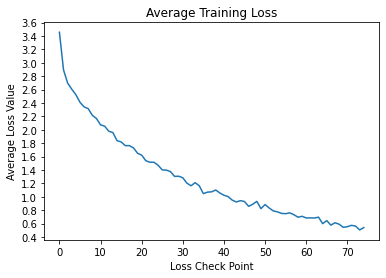

In [16]:
teacher_forcing_ratio = 0.5 #Freq real target outputs are used as next input
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               dropout_p=0.1).to(device)
#trainIters(encoder1, attn_decoder1, 100, print_every=20) #short training
model1Losses = trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [17]:
evaluateRandomly(encoder1, attn_decoder1)

> nous sommes une equipe .
= we re a team .
< we re a team . <EOS>

> il n est pas du tout honnete .
= he is not honest at all .
< he is not honest at all . <EOS>

> ils sont aussi forts que nous .
= they are as strong as us .
< they are as strong as us . <EOS>

> il a beaucoup d experience .
= he s very experienced .
< he s raking it . <EOS>

> je suis si epuise !
= i am so exhausted !
< i m so exhausted ! <EOS>

> tu n es pas normale .
= you re not normal .
< you re not normal . <EOS>

> vous etes tres brave .
= you re very brave .
< you re very brave . <EOS>

> je suis dans le jardin .
= i am in the garden .
< i m in the boat . <EOS>

> vous etes un merveilleux ami .
= you re a wonderful friend .
< you re a wonderful friend . <EOS>

> il est toujours cloue au lit .
= he s still sick in bed .
< he s still sick of . <EOS>



In [18]:
#Display Languages 
print(f"Input language name: {input_lang.name}")
print(f"Output language name: {output_lang.name}")

Input language name: fra
Output language name: eng


### Exporting Language Models

In [1]:
with open(f'{input_lang.name}_index2word.txt', 'w') as f:
    f.write(str(input_lang.index2word))
    f.close()
    
with open(f'{output_lang.name}_index2word.txt', 'w') as f:
    f.write(str(output_lang.index2word))
    f.close()

print(f"Input language ({input_lang.name}) and output language ({output_lang.name}) models exported as {input_lang.name}_index2word.txt and {output_lang.name}_index2word.txt")

NameError: name 'input_lang' is not defined

### Exporting the Encoder and Decoder

In [22]:
print(encoder1.eval())
print(attn_decoder1.eval())

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)
AttnDecoderRNN(
  (embedding): Embedding(2803, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2803, bias=True)
)


In [39]:
with open(f'{input_lang.name}_{output_lang.name}_meta.txt', 'w') as f:
    f.write(f'hidden_size: {hidden_size}\n')
    f.write(f'input_lang.n_words: {input_lang.n_words}\n')
    f.write(f'output_lang.n_words: {output_lang.n_words}\n')
    f.write(f'Attn_additional: dropout_p={0.1}\n')
    f.close()

In [21]:
torch.save(encoder1.state_dict(), 
           f'encoder_{input_lang.name}_{output_lang.name}_weights.pth')
torch.save(attn_decoder1.state_dict(), 
           f'attn_decoder_{input_lang.name}_{output_lang.name}_weights.pth')
print("Encoder and Attention Decoder weights saved.")

Encoder and Attention Decoder weights saved.


### Reloading the Model

In [28]:
encoderReload = EncoderRNN(input_lang.n_words, hidden_size)
encoderReload.load_state_dict(torch.load(f'encoder_{input_lang.name}_{output_lang.name}_weights.pth'))
encoderReload.eval()

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)

In [32]:
attn_decoderReload = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               dropout_p=0.1)
attn_decoderReload.load_state_dict(torch.load(f'attn_decoder_{input_lang.name}_{output_lang.name}_weights.pth'))
attn_decoderReload.eval()

AttnDecoderRNN(
  (embedding): Embedding(2803, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2803, bias=True)
)

### Reload Test

In [33]:
evaluateRandomly(encoderReload, attn_decoderReload)

> vous etes trop jeunes pour voyager seules .
= you are too young to travel alone .
< you are too young to travel alone . <EOS>

> tu es courtois .
= you re courteous .
< you re courteous . <EOS>

> j oublie toujours le nom des gens .
= i m always forgetting people s names .
< i m always forgetting people s names . <EOS>

> c est vous la plus vieille .
= you re the oldest .
< you re the oldest . <EOS>

> ils sont fauches .
= they re broke .
< they re broke . <EOS>

> il a peur de nager .
= he is afraid of swimming .
< he is afraid of swim . <EOS>

> je ressens beaucoup d hostilite .
= i m sensing a lot of hostility .
< i m getting out of practice . <EOS>

> vous n etes pas normales .
= you re not normal .
< you re not normal . <EOS>

> il a probablement tort .
= he s probably wrong .
< he s probably wrong . <EOS>

> tu preches des convaincues .
= you re preaching to the choir .
< you re preaching to the choir . <EOS>



<br>